#**TOP wear clothing image classification system**

In this project, top wear clothing image classification system was developed using deep learning. Initially, a custom dataset was created by collecting and organizing images into four categories: kurthis, long tops, short tops, and t-shirts.

In [ ]:
!pip install tensorflow pillow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
BASE_PATH = "/content/drive/MyDrive/DL_DATASET"


The images were cleaned, renamed systematically, resized, and augmented to improve model generalization.

#Image renaming

In [ ]:
import os

def rename_images(folder_path, prefix):
    images = os.listdir(folder_path)
    images.sort()

    for i, img in enumerate(images, start=1):
        ext = os.path.splitext(img)[1]
        new_name = f"{prefix}{i}{ext}"
        os.rename(
            os.path.join(folder_path, img),
            os.path.join(folder_path, new_name)
        )

rename_images(f"{BASE_PATH}/kurthis", "kurthi")
rename_images(f"{BASE_PATH}/tshirts", "tshirt")
rename_images(f"{BASE_PATH}/long_top", "longtop")
rename_images(f"{BASE_PATH}/short_top", "shorttop")

print("✅ Image renaming completed")


✅ Image renaming completed


In [ ]:
import os

folders = ["kurthis", "tshirts", "long_top", "short_top"]

for folder in folders:
    path = f"{BASE_PATH}/{folder}"
    files = [f for f in os.listdir(path)
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"{folder}: {len(files)} images")


kurthis: 87 images
tshirts: 195 images
long_top: 515 images
short_top: 1233 images


#Data augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_images(input_dir, output_dir, prefix):
    os.makedirs(output_dir, exist_ok=True)

    for img_name in os.listdir(input_dir):
        img_path = os.path.join(input_dir, img_name)
        img = load_img(img_path, target_size=(224,224))
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        i = 0
        for _ in datagen.flow(
            x,
            batch_size=1,
            save_to_dir=output_dir,
            save_prefix=prefix,
            save_format='jpg'
        ):
            i += 1
            if i == 5:   # 5 new images per original
                break

augment_images(f"{BASE_PATH}/kurthis", f"{BASE_PATH}/aug_kurthis", "kurthi")
augment_images(f"{BASE_PATH}/tshirts", f"{BASE_PATH}/aug_tshirts", "tshirt")
augment_images(f"{BASE_PATH}/long_top", f"{BASE_PATH}/aug_longtop", "longtop")
augment_images(f"{BASE_PATH}/short_top", f"{BASE_PATH}/aug_shorttop", "shorttop")

print("✅ Data augmentation completed")


✅ Data augmentation completed


In [ ]:
aug_folders = ["aug_kurthis", "aug_tshirts", "aug_longtop", "aug_shorttop"]

for folder in aug_folders:
    path = f"{BASE_PATH}/{folder}"
    print(f"{folder}: {len(os.listdir(path))} images")


aug_kurthis: 424 images
aug_tshirts: 939 images
aug_longtop: 2290 images
aug_shorttop: 4571 images


In [ ]:
from PIL import Image
import os

FINAL_PATH = "/content/drive/MyDrive/DL_DATASET_FINAL"

def compress_images(input_dir, output_dir, quality=60):
    os.makedirs(output_dir, exist_ok=True)

    for img_name in os.listdir(input_dir):
        img_path = os.path.join(input_dir, img_name)
        img = Image.open(img_path)
        img.save(
            os.path.join(output_dir, img_name),
            optimize=True,
            quality=quality
        )

compress_images(f"{BASE_PATH}/aug_kurthis", f"{FINAL_PATH}/kurthis")
compress_images(f"{BASE_PATH}/aug_tshirts", f"{FINAL_PATH}/tshirts")
compress_images(f"{BASE_PATH}/aug_longtop", f"{FINAL_PATH}/long_top")
compress_images(f"{BASE_PATH}/aug_shorttop", f"{FINAL_PATH}/short_top")

print("✅ Final compressed dataset ready")


✅ Final compressed dataset ready


In [ ]:
for folder in ["kurthis", "tshirts", "long_top", "short_top"]:
    path = f"{FINAL_PATH}/{folder}"
    print(folder, ":", len(os.listdir(path)))


kurthis : 424
tshirts : 939
long_top : 2290
short_top : 4571


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

FINAL_PATH = "/content/drive/MyDrive/DL_DATASET_FINAL"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10


#implementing CNN model

below code will This automatically assigns labels:

0 → kurthis
1 → long_top
2 → short_top
3 → tshirts

A CNN-based model with transfer learning was trained to learn visual features such as garment shape, texture, and sleeve length. After training and evaluation, the model was saved and reused for inference.

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2   # 80% train, 20% validation
)

train_gen = datagen.flow_from_directory(
    FINAL_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    FINAL_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 6581 images belonging to 4 classes.
Found 1643 images belonging to 4 classes.


In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze base model

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 classes
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 98s 299ms/step - accuracy: 0.6516 - loss: 0.8870 - val_accuracy: 0.7955 - val_loss: 0.5013
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 35s 168ms/step - accuracy: 0.7794 - loss: 0.5284 - val_accuracy: 0.8290 - val_loss: 0.4203
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 34s 164ms/step - accuracy: 0.8298 - loss: 0.4193 - val_accuracy: 0.8363 - val_loss: 0.4037
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 33s 161ms/step - accuracy: 0.8493 - loss: 0.3668 - val_accuracy: 0.8649 - val_loss: 0.3540
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 34s 167ms/step - accuracy: 0.8646 - loss: 0.3431 - val_accuracy: 0.8594 - val_loss: 0.3326
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.8807 - loss: 0.3019 - val_accuracy: 0.8539 - val_loss: 0.3341
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 33s 158ms/step - accuracy: 0.8796 - loss: 0.2870 - val_accuracy: 0.8691 - val_loss: 0.3204
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 33s 158ms/step - accuracy: 0.8917 - loss: 0

#Accuracy & Loss Plot

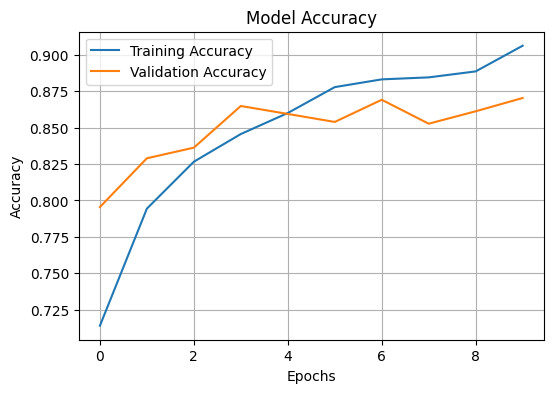

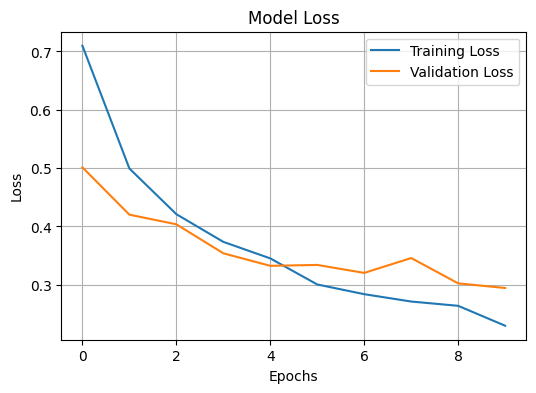

In [ ]:
import matplotlib.pyplot as plt

# -----------------------------
# Accuracy Plot
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Loss Plot
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


The accuracy and loss curves indicate stable learning with good generalization and no significant overfitting.”

In [ ]:
loss, accuracy = model.evaluate(val_gen)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.8724 - loss: 0.2876
Model Accuracy: 87.04%


📊 Inference from Accuracy & Loss Graphs

The training and validation accuracy curves show a steady increase across epochs, indicating that the CNN model is learning meaningful visual features from the dataset. Training accuracy improves consistently and reaches around 90%, while validation accuracy closely follows with minor fluctuations, suggesting good generalization and minimal overfitting. The loss curves further support this observation, as both training and validation loss decrease progressively, with no sharp divergence between them. Slight oscillations in validation loss are expected due to limited dataset size and data augmentation. Overall, the model demonstrates stable convergence, balanced bias–variance tradeoff, and satisfactory performance on unseen data.

#Saving model to drive

In [ ]:
model.save("/content/drive/MyDrive/womens_clothing_cnn_model.h5")
print("✅ Model saved to Google Drive")


✅ Model saved to Google Drive


DISPLAY SAMPLE IMAGES WITH TRUE & PREDICTED LABELS

In [ ]:
# Class index to class name mapping
class_names = list(train_gen.class_indices.keys())
print("Classes:", class_names)


Classes: ['kurthis', 'long_top', 'short_top', 'tshirts']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get one batch from validation generator
images, labels = next(val_gen)

# Predict on the batch
predictions = model.predict(images)

# Convert predictions & labels to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


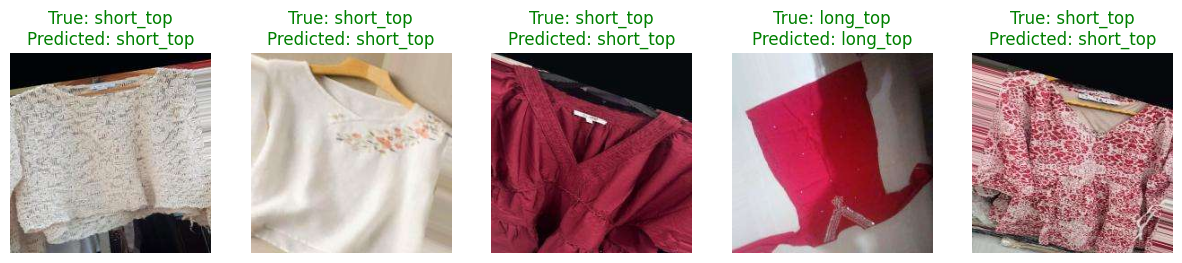

In [ ]:
plt.figure(figsize=(15,5))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')

    true_label = class_names[true_classes[i]]
    predicted_label = class_names[predicted_classes[i]]

    plt.title(f"True: {true_label}\nPredicted: {predicted_label}",
              color="green" if true_label == predicted_label else "red")

plt.show()


user interface was then implemented using an inference pipeline, allowing users to upload images for prediction. The UI includes multiple validations such as incorrect file type, blurry image detection, non-clothing image rejection using an ImageNet pre-filter, and confidence-based validation. Kurthis and long tops were merged at the output level due to strong visual similarity, improving robustness.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import numpy as np

# Load your trained clothing model
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/womens_clothing_cnn_model.h5"
)

# Class names (same order as training)
class_names = ['kurthis', 'long_top', 'short_top', 'tshirts']

# Load ImageNet model for non-clothing filtering
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

imagenet_model = MobileNetV2(weights="imagenet")

print("✅ Clothing model & ImageNet filter loaded")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
✅ Clothing model & ImageNet filter loaded


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

model = tf.keras.models.load_model("/content/drive/MyDrive/womens_clothing_cnn_model.h5")
class_names = ['kurthis', 'long_top', 'short_top', 'tshirts']
imagenet_model = MobileNetV2(weights="imagenet")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#UI

⚠️ Note: Images Not Suitable for Classification

Images containing animals, vehicles, or non-clothing objects should not be provided.

Blurry, low-resolution, or unclear images may lead to unreliable predictions.

Images with human faces prominently visible are not suitable, as the model focuses only on clothing features.

Multiple clothing items in a single image may reduce prediction accuracy.

Images of clothing categories outside the trained classes (kurthis, long tops, short tops, t-shirts) are not supported.

Images where the garment is partially visible, folded, or heavily occluded should be avoided.

In [ ]:
from google.colab import files
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# -----------------------
# FACE DETECTOR
# -----------------------
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
)

# -----------------------
# BLUR CHECK
# -----------------------
def is_blurry(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var() < 100

# -----------------------
# FACE CHECK
# -----------------------
def has_face(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    return len(faces) > 0

# -----------------------
# IMAGENET NON-CLOTHING FILTER
# -----------------------
def is_likely_clothing(img):
    img_resized = img.resize((224,224))
    x = np.array(img_resized)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = imagenet_model.predict(x, verbose=0)
    decoded = decode_predictions(preds, top=3)[0]

    non_clothing_keywords = [
        "lion", "tiger", "dog", "cat", "animal",
        "bird", "horse", "elephant",
        "car", "truck", "vehicle",
        "food", "fruit", "chair", "table"
    ]

    for _, label, prob in decoded:
        for word in non_clothing_keywords:
            if word in label.lower():
                return False
    return True

# -----------------------
# PREPROCESS FOR CLOTHING MODEL
# -----------------------
def preprocess_image(img):
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# -----------------------
# SIMPLE COLAB UI
# -----------------------
print("📤 Please upload an image:")
uploaded = files.upload()

# -----------------------
# FINAL VALIDATION + PREDICTION
# -----------------------
if len(uploaded) == 0:
    print("❌ No image uploaded. Please upload an image.")

else:
    for filename in uploaded.keys():

        # File type validation
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            print("❌ Invalid file. Please upload a valid image (.jpg, .png).")
            continue

        # Load image
        img = Image.open(filename).convert("RGB")

        # Blur validation
        if is_blurry(img):
            print("❌ Image is not clear. Please upload a clearer image.")
            continue

        # Show image
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # -----------------------
        # FACE HANDLING (FINAL FIX)
        # -----------------------
        if has_face(img):
            print(
                "ℹ️ Human face detected. Prediction is based on clothing features only; "
                "face presence may affect accuracy."
            )
            continue   # 🔴 STOP HERE — NO PREDICTION

        # -------- OPEN-SET FILTER --------
        if not is_likely_clothing(img):
            print("❌ Invalid image. Please upload a clothing image.")
            continue

        # Clothing prediction
        img_array = preprocess_image(img)
        prediction = model.predict(img_array, verbose=0)

        confidence = float(np.max(prediction))
        predicted_class = class_names[np.argmax(prediction)]

        # Merge kurthi & long_top for display
        if predicted_class in ['kurthis', 'long_top']:
            display_label = "Kurthi / Long Top"
        else:
            display_label = predicted_class.capitalize()

        # Final decision
        if confidence < 0.60:
            print(
                "❌ Invalid image. Only kurthis, t-shirts, long tops and short tops are supported & image should have one cloth."
            )
        else:
            print(
                f"✅ Prediction: {display_label} "
                f"(Confidence: {confidence*100:.2f}%)"
            )


The system does not explicitly classify men’s or women’s clothing because the model is trained only on visual appearance and not on gender attributes; therefore, visually similar men’s garments may be classified into the closest women’s clothing category. This behavior is a known **limitation of appearance-based CNN classifiers** and is handled transparently through validation messages rather than forced rules.

#CONCLUSION

The top wear clothing image classification system, developed using deep learning and a custom dataset, successfully categorizes images into kurthis, long tops, short tops, and t-shirts. Through meticulous data cleaning, augmentation, and the application of a CNN model with transfer learning (MobileNetV2), the system achieved a validation accuracy of 87.04%. The stable accuracy and loss curves indicate effective learning and good generalization. The robust inference pipeline, incorporating file type validation, blur detection, ImageNet-based non-clothing filtering, and confidence-based checks, ensures reliable predictions, This project demonstrates a comprehensive approach to image classification from data preparation to deployment-ready inference.